### Assignment2
12112124

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import h3
import folium


In [2]:
orders_data = pd.read_csv('datasets/data_orders.csv')


#### Q1

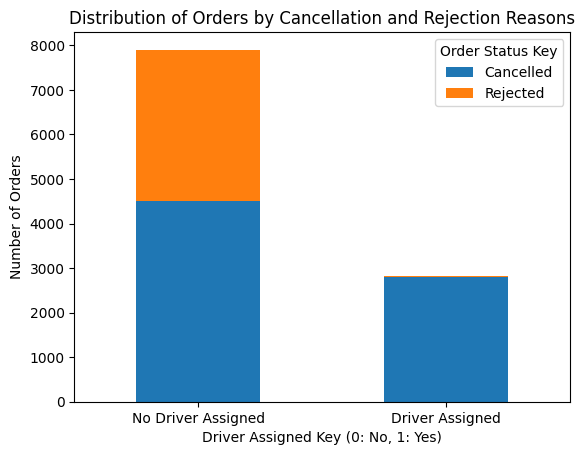

order_status_key,4,9
is_driver_assigned_key,,
0,4496,3406
1,2811,3


In [3]:
cancellations_and_rejections = orders_data[orders_data['order_status_key'].isin([4, 9])]

cancellation_rejection_distribution = cancellations_and_rejections.groupby(['is_driver_assigned_key', 'order_status_key']).size().unstack(fill_value=0)

cancellation_rejection_distribution.plot(kind='bar', stacked=True)
plt.title('Distribution of Orders by Cancellation and Rejection Reasons')
plt.xlabel('Driver Assigned Key (0: No, 1: Yes)')
plt.ylabel('Number of Orders')
plt.xticks(ticks=[0, 1], labels=['No Driver Assigned', 'Driver Assigned'], rotation=0)
plt.legend(title='Order Status Key', labels=['Cancelled', 'Rejected'])
plt.show()

cancellation_rejection_distribution


According to the distribution diagram of driver assignment status and order status code, we can see:

When no driver was assigned (is_driver_assigned_key was 0), 4,496 orders were canceled and 3,406 orders were rejected.

When the driver was assigned (is_driver_assigned_key was 1), 2,811 orders were canceled, while only 3 orders were rejected.

This indicates that slightly more orders were cancelled than rejected before drivers were assigned, whereas once drivers were assigned, order cancellations were more common and almost no order rejections occurred.

#### Q2

C:\Users\18219\AppData\Local\Temp\ipykernel_10572\1735961789.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  orders_data['hour'] = pd.to_datetime(orders_data['order_datetime']).dt.hour


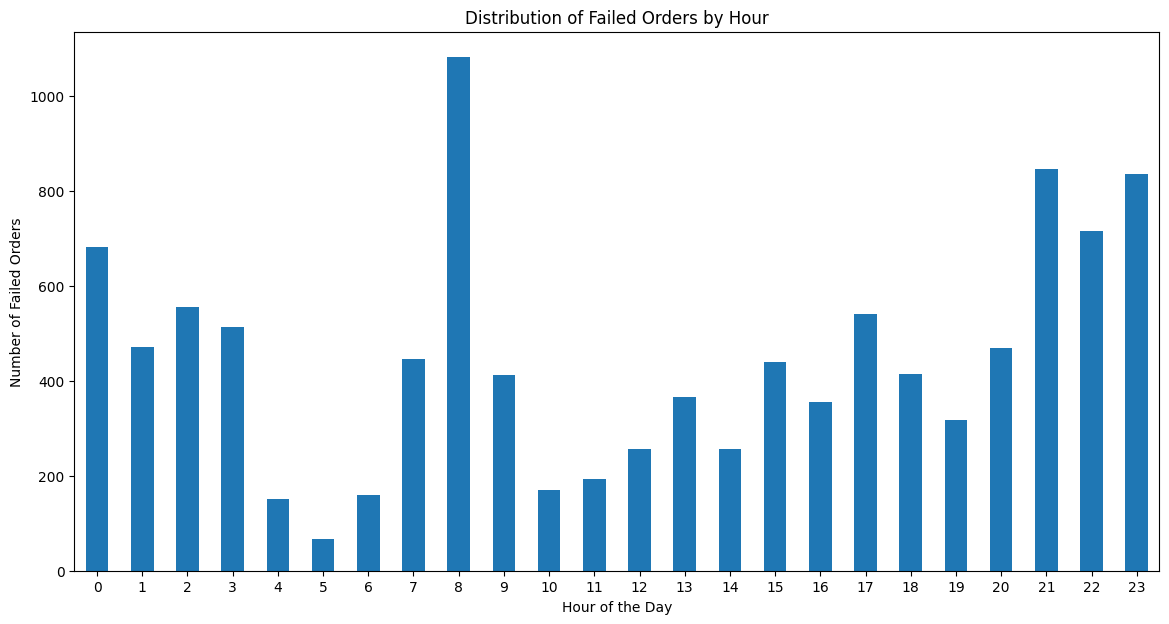

hour
0      683
1      471
2      555
3      513
4      152
5       67
6      159
7      447
8     1082
9      412
10     170
11     193
12     256
13     366
14     256
15     439
16     356
17     541
18     414
19     317
20     469
21     846
22     716
23     836
Name: count, dtype: int64

In [4]:
orders_data['hour'] = pd.to_datetime(orders_data['order_datetime']).dt.hour

failed_orders = orders_data[orders_data['order_status_key'].isin([4, 9])]

failed_orders_by_hour = failed_orders['hour'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
failed_orders_by_hour.plot(kind='bar')
plt.title('Distribution of Failed Orders by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Failed Orders')
plt.xticks(rotation=0)
plt.show()

failed_orders_by_hour


As you can see from the chart, there are some peaks and troughs in the distribution of failed orders throughout the day. In particular during the following time periods:

Between 1am (471 failed orders) and 4am (513 failed orders), the number of failed orders was relatively small.
There was a clear peak at 8am, with 1,082 failed orders.
There were also peaks in the number of failed orders at 21 PM (846 failed orders) and 23 PM (836 failed orders).

This pattern may be related to user ordering habits, such as the morning and evening peak hours, which may lead to an increase in failed orders due to high demand. The lower order volume at night may be due to reduced user activity.

#### Q3

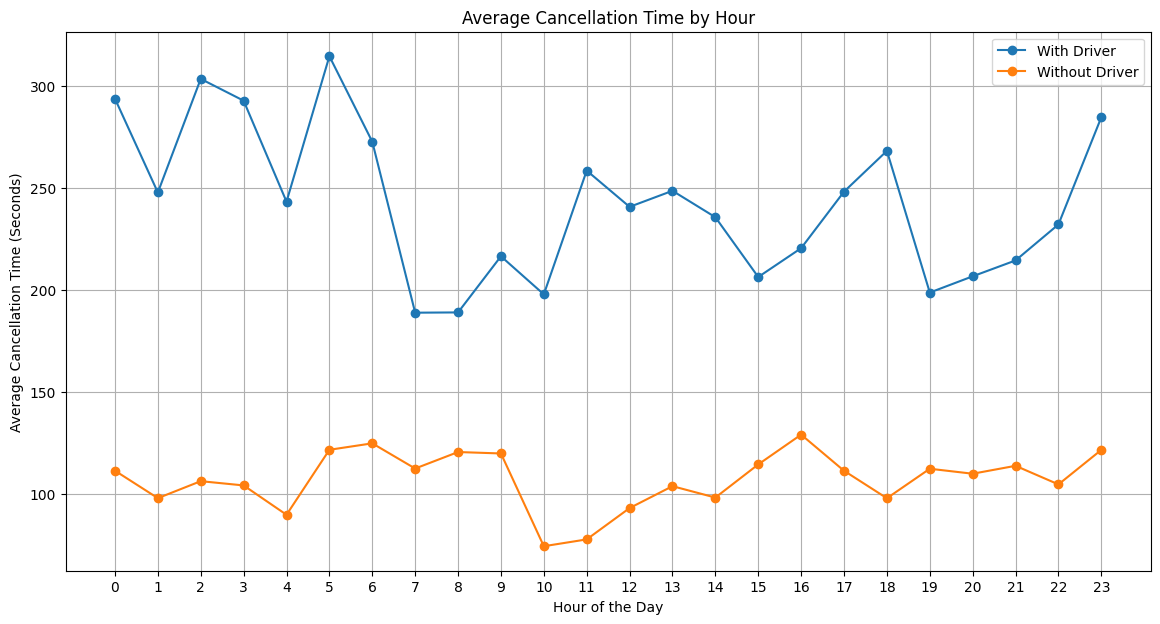

(hour
 0     293.616667
 1     247.715909
 2     303.307692
 3     292.640625
 4     243.219512
 5     314.400000
 6     272.553191
 7     188.891026
 8     189.025478
 9     216.493590
 10    197.860759
 11    258.423423
 12    240.686869
 13    248.541667
 14    235.618557
 15    206.349650
 16    220.465649
 17    248.125749
 18    268.082090
 19    198.741667
 20    206.692982
 21    214.460784
 22    232.080537
 23    284.557692
 Name: cancellations_time_in_seconds, dtype: float64,
 hour
 0     111.557047
 1      98.132420
 2     106.438819
 3     104.361607
 4      90.000000
 5     121.800000
 6     124.955224
 7     112.628049
 8     120.702179
 9     120.000000
 10     74.607843
 11     77.945455
 12     93.283019
 13    103.993243
 14     98.415094
 15    114.639535
 16    129.216783
 17    111.533040
 18     98.088608
 19    112.522124
 20    110.086957
 21    113.959821
 22    104.858896
 23    121.756614
 Name: cancellations_time_in_seconds, dtype: float64)

In [5]:
cancelled_orders = orders_data[orders_data['order_status_key'] == 4]

avg_cancellation_time_with_driver = cancelled_orders[cancelled_orders['is_driver_assigned_key'] == 1].groupby('hour')['cancellations_time_in_seconds'].mean()
avg_cancellation_time_without_driver = cancelled_orders[cancelled_orders['is_driver_assigned_key'] == 0].groupby('hour')['cancellations_time_in_seconds'].mean()

plt.figure(figsize=(14, 7))

plt.plot(avg_cancellation_time_with_driver.index, avg_cancellation_time_with_driver.values, label='With Driver', marker='o')

plt.plot(avg_cancellation_time_without_driver.index, avg_cancellation_time_without_driver.values, label='Without Driver', marker='o')

plt.title('Average Cancellation Time by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Cancellation Time (Seconds)')
plt.xticks(range(24))  
plt.legend()
plt.grid(True)
plt.show()

avg_cancellation_time_with_driver, avg_cancellation_time_without_driver


The chart shows the average cancellation time per hour, distinguishing between those assigned with and without a driver. We can see that:

In most hours, the average cancellation time for orders with a driver assigned was longer than for orders without a driver assigned.

Between 4 a.m. and 6 a.m., there is a small spike in the average cancellation time when there is no driver assigned.

Between 7 a.m. and 9 a.m., the average cancellation time with a driver assigned dropped significantly, possibly due to drivers responding more quickly to cancellations in the morning peak hours or customers deciding to cancel orders more quickly.

Between 21 and 23 p.m., the average cancellation time when there is no driver assigned is relatively stable.

These variations may be related to different activity patterns and service demands throughout the day, for example a quick response in the morning may be due to high driver availability, and in the evening it may be due to a lower number of orders leading to more rapid cancellation operations.

#### Q4

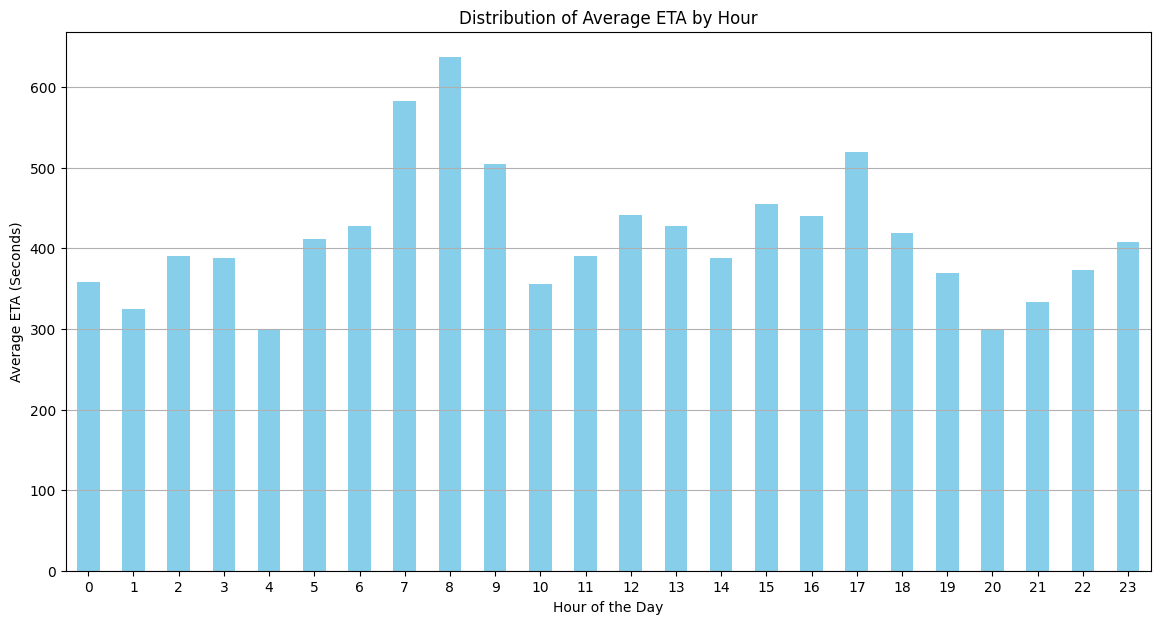

hour
0     357.959016
1     324.750000
2     391.012821
3     388.093750
4     299.658537
5     411.120000
6     427.148936
7     583.358974
8     636.910828
9     504.891026
10    355.556962
11    390.954955
12    440.787879
13    428.025000
14    387.835052
15    454.790210
16    440.568182
17    519.742515
18    419.186567
19    369.816667
20    300.096491
21    333.852941
22    372.744966
23    408.429487
Name: m_order_eta, dtype: float64

In [6]:
avg_eta_by_hour = orders_data.groupby('hour')['m_order_eta'].mean()

plt.figure(figsize=(14, 7))
avg_eta_by_hour.plot(kind='bar', color='skyblue')

plt.title('Distribution of Average ETA by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA (Seconds)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

avg_eta_by_hour


From the chart, we can observe that:

The average ETA peaks between 7 and 8 a.m., which may be related to traffic congestion during the morning rush hour, leading to increased delivery times.

The average ETA is lower during late night and early morning hours, such as 4 a.m., probably because there is less traffic, which reduces delivery times.
There was an increase in ETA in the afternoon, probably due to increased traffic in the afternoon to early evening.

The average ETA begins to decline after 20pm, which may reflect a decrease in traffic in the evening.

This distribution may reflect changes in traffic flow throughout the day in the city, which has a direct impact on order delivery times. Low traffic at night and in the morning leads to shorter delivery times, while congestion during rush hour leads to longer delivery times.

#### Q5

In [7]:
h3_resolution = 8

orders_data['h3_index'] = orders_data.apply(lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], h3_resolution), axis=1)

hex_orders_count = orders_data['h3_index'].value_counts()

cutoff = hex_orders_count.sum() * 0.8
cumulative_count = hex_orders_count.cumsum()
hexes_to_include = cumulative_count[cumulative_count <= cutoff].index

m = folium.Map(location=[orders_data['origin_latitude'].mean(), orders_data['origin_longitude'].mean()], zoom_start=12)

for hex_id in hexes_to_include:
    polygon = folium.Polygon(locations=h3.h3_to_geo_boundary(hex_id), color='blue', fill_color='blue', fill_opacity=0.6)
    m.add_child(polygon)

m.save('hex_map.html')
